# Marginal effects
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import signal, stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

Data locations

In [2]:
loc_coefs = "../Data/RegressionResults/"
loc_panel = "../Data/Panel/"
loc_shp = "../Data/ProcessedCountryShapefile/"

Panel info

In [3]:
y1 = 1960
y2 = 2019

Shapefile

In [4]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values

#### Analysis

Read coefs and interactions

In [5]:
phase = "ENSO"
enso_var = "e"
response = "gr_pwt_frac"
trend = "none"
nlag = 5
lags = np.arange(0,nlag+1,1)

In [6]:
enso_coefs_e = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_e_e-and-c_"+response+"_trend"+trend+".csv",index_col=0)
int_coefs_e = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_e_e-and-c_"+response+"_trend"+trend+".csv",index_col=0)
nboot = len(int_coefs_e.coef_lag0.values)

enso_coefs_c = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_c_e-and-c_"+response+"_trend"+trend+".csv",index_col=0)
int_coefs_c = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_c_e-and-c_"+response+"_trend"+trend+".csv",index_col=0)

In [7]:
np.mean(enso_coefs_e.iloc[:,1:].values,axis=0)

array([0.00679677, 0.0021547 , 0.00559967, 0.00818328, 0.00542004,
       0.00641149])

In [8]:
np.mean(int_coefs_e.iloc[:,1:].values,axis=0)

array([-0.01658342, -0.00750653, -0.01613889, -0.01710249, -0.01261906,
       -0.01216662])

Read in panel to get distribution of teleconnection strengths

In [9]:
panel = pd.read_csv(loc_panel+"ENSO_Growth_Panel_"+str(y1)+"-"+str(y2)+".csv",index_col=0)
#panel_corrs = panel.t_p_corr_sum_e.values

Get separate teleconnection metrics

In [10]:
# t_p_corr_running_e

In [11]:
e_teleconnection = panel.loc[panel.year==2010,"t_p_corr_running_e"].values
c_teleconnection = panel.loc[panel.year==2010,"t_p_corr_running_c"].values
e_teleconnection_centered = e_teleconnection - np.nanmean(e_teleconnection)
c_teleconnection_centered = c_teleconnection - np.nanmean(c_teleconnection)
#ind = (~np.isnan(e_teleconnection_centered))&(~np.isnan(c_teleconnection_centered))
ind = (~np.isnan(e_teleconnection))&(~np.isnan(c_teleconnection))

Create marginal effects

In [12]:
#corrs = np.arange(2,12+0.025,0.025)
corrs = np.arange(0.25,1.4+0.01,0.01)

In [13]:
corr_means_e = np.zeros((len(corrs),nlag+1))
corr_upper_e = np.zeros((len(corrs),nlag+1))
corr_lower_e = np.zeros((len(corrs),nlag+1))

corr_means_c = np.zeros((len(corrs),nlag+1))
corr_upper_c = np.zeros((len(corrs),nlag+1))
corr_lower_c = np.zeros((len(corrs),nlag+1))

In [14]:
for c in corrs:
    corr_indiv_e = np.zeros((nboot,nlag+1))
    corr_indiv_c = np.zeros((nboot,nlag+1))
    for l in np.arange(0,nlag+1,1):
        enso_coef_e = enso_coefs_e.loc[:,"coef_lag"+str(l)].values
        int_coef_e = int_coefs_e.loc[:,"coef_lag"+str(l)].values
        corr_indiv_e[:,l] = enso_coef_e + (int_coef_e * c)
        enso_coef_c = enso_coefs_c.loc[:,"coef_lag"+str(l)].values
        int_coef_c = int_coefs_c.loc[:,"coef_lag"+str(l)].values
        corr_indiv_c[:,l] = enso_coef_c + (int_coef_c * c)
        
    cumulative_e = np.cumsum(corr_indiv_e,axis=1)
    corr_means_e[list(corrs).index(c),:] = np.mean(cumulative_e,axis=0)
    corr_upper_e[list(corrs).index(c),:] = np.percentile(cumulative_e,97.5,axis=0)
    corr_lower_e[list(corrs).index(c),:] = np.percentile(cumulative_e,2.5,axis=0)
    
    cumulative_c = np.cumsum(corr_indiv_c,axis=1)
    corr_means_c[list(corrs).index(c),:] = np.mean(cumulative_c,axis=0)
    corr_upper_c[list(corrs).index(c),:] = np.percentile(cumulative_c,97.5,axis=0)
    corr_lower_c[list(corrs).index(c),:] = np.percentile(cumulative_c,2.5,axis=0)

Plot E and C teleconnections and effects

-8.039788798934186
1.5372828457250651


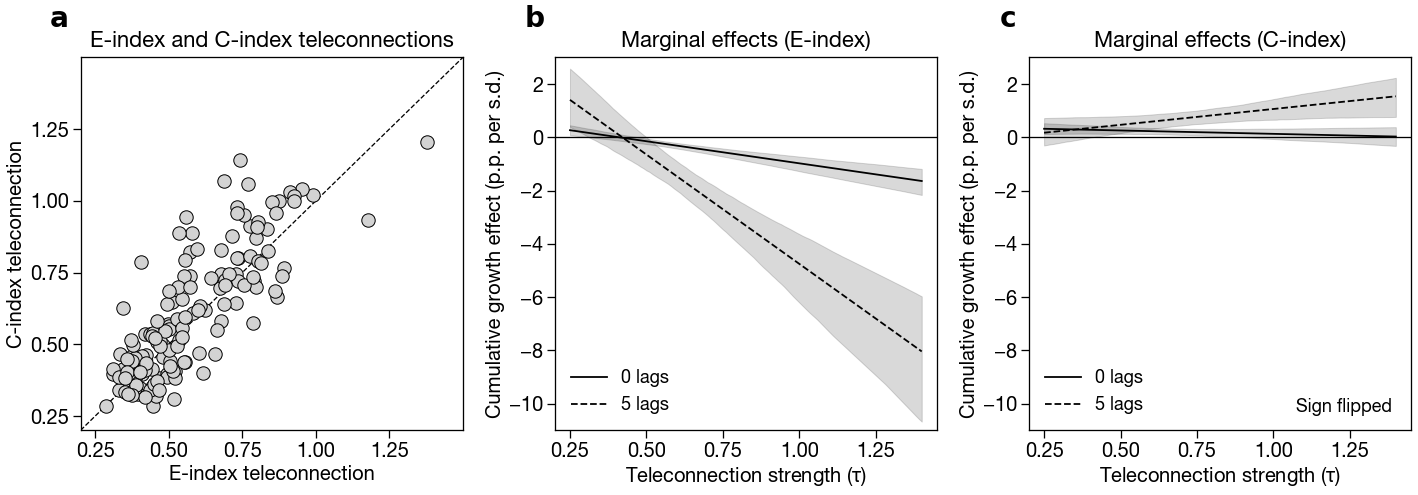

In [15]:
fig = plt.figure(figsize=(22,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs2 = gridspec.GridSpec(1,3)
gs2.update(left=0.1,right=0.94,top=0.87,bottom=0.13,wspace=0.24,hspace=0.23)


ax = plt.subplot(gs2[0,0])

plt.scatter(e_teleconnection[ind],c_teleconnection[ind],
          facecolor="lightgray",edgecolor="black",s=180,zorder=2)


plt.xlim([0.2,1.5])
plt.ylim([0.2,1.5])
#tks = np.arange(-,8+2,2)
#plt.xticks(tks)
#plt.yticks(tks)
plt.xticks([0.25,0.5,0.75,1,1.25])
plt.yticks([0.25,0.5,0.75,1,1.25])

plt.plot([0.2,1.5],[0.2,1.5],linewidth=1.3,color="black",
         linestyle="--",zorder=1)

plt.xlabel("E-index teleconnection")
plt.ylabel("C-index teleconnection")

plt.title("E-index and C-index teleconnections",fontsize=22,pad=10)



for j in [1,2]:

    ax = plt.subplot(gs2[0,j])
    #ax.spines["right"].set_visible(False)
    #ax.spines["top"].set_visible(False)
    if j == 1:
        corr_means = corr_means_e
        corr_upper = corr_upper_e
        corr_lower = corr_lower_e
    else:
        corr_means = corr_means_c*-1.0
        corr_upper = corr_upper_c*-1.0
        corr_lower = corr_lower_c*-1.0
        
    # cols
    lag0_col = "black" #np.array([34,136,51])/255.
    lag5_col = "black" #np.array([68,119,170])/255.
    lag0_lt = "-"
    lag2_lt = "--"
    alph = 0.15

    # lag0
    mn = corr_means[:,0]*100
    upper = corr_upper[:,0]*100
    lower = corr_lower[:,0]*100
    plt.plot(corrs,mn,color=lag0_col,linewidth=1.8,label="0 lags",
            zorder=2,linestyle=lag0_lt)
    ax.fill_between(corrs,lower,upper,
                    color=lag0_col,
                    alpha=alph,zorder=2)

    # lag5
    mn = corr_means[:,-1]*100
    upper = corr_upper[:,-1]*100
    lower = corr_lower[:,-1]*100
    plt.plot(corrs,mn,color=lag5_col,linewidth=1.8,label="5 lags",
            zorder=1,linestyle=lag2_lt)
    ax.fill_between(corrs,lower,upper,
                    color=lag5_col,
                    alpha=alph,zorder=1)

    print(mn[np.argmin(np.abs(corrs-7))])
    plt.axhline(y=0,linewidth=1.3,color="black",linestyle="-")

    plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
    plt.xlabel("Teleconnection strength ("+r"$\tau$)")

    plt.ylim([-11,3])
    #plt.yticks([-6,-5,-4,-3,-2,-1,0,1,2])
    #plt.yticks(np.arange(-6,2+1,2))
    plt.xlim([0.2,1.45])
    #plt.xticks([0.2,0.4,0.6,0.8,1.0,1.2,1.4])
    if j == 1:
        plt.title("Marginal effects (E-index)",pad=10,fontsize=22)
    else:
        plt.title("Marginal effects (C-index)",pad=10,fontsize=22)
        plt.text(0.7,0.05,"Sign flipped",fontsize=18,transform=ax.transAxes)
    plt.legend(loc="lower left",frameon=False,fontsize=18)

    
plt.figtext(0.08,0.93,r'$\bf{a}$',fontsize=28)
plt.figtext(0.38,0.93,r'$\bf{b}$',fontsize=28)
plt.figtext(0.68,0.93,r'$\bf{c}$',fontsize=28)
    
plt.savefig("../Figures/FigX_E_C_Effects.pdf")
plt.show()

In [16]:
np.nanmin(e_teleconnection)

0.2852641025023439

In [17]:
x = e_teleconnection[(~np.isnan(e_teleconnection))&(~np.isnan(c_teleconnection))]
y = c_teleconnection[(~np.isnan(e_teleconnection))&(~np.isnan(c_teleconnection))]

In [18]:
effect_ratio = corr_means_e[:,-1]/corr_means_c[:,-1]

In [19]:
corrs[effect_ratio>2]

array([0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 ])

In [20]:
corrs[effect_ratio>4]

array([0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96,
       0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07,
       1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18,
       1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29,
       1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 ])

In [21]:
# use 1.3 as example because peru and ecuador are on either side of 1.3 for tau^e

In [22]:
corr_means_e[np.argmin(np.abs(corrs-1.3)),-1]

-0.07218618580553587

In [23]:
corr_means_c[np.argmin(np.abs(corrs-1.3)),-1]

-0.014183840538264748